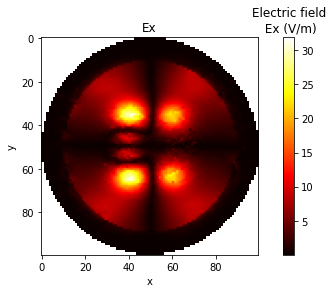

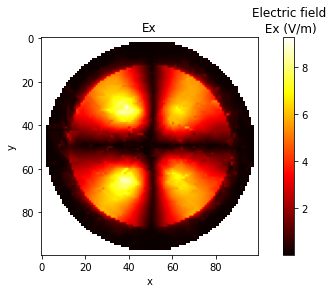

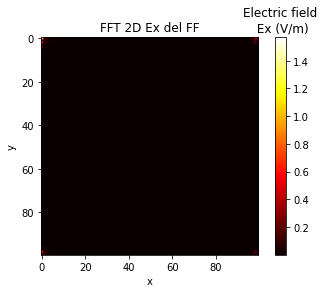

FIN PROGRAMA


In [11]:
__author__ = "joseluis"

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator


mu0 = 4*np.pi*1e-7
c0 = 299792458
raw_data = 9

pauseinterval = 0.01

argstructure={'directory':r'c:\\Users\\aitor\\OneDrive\\Desktop\\TFG-AitorIngelmo\\Codigos\\NF to NF\\codigo JL',
              'filename_Ex':'microstrip_patch_antenna_Ex.txt',
              'filename_Ey':'microstrip_patch_antenna_Ey.txt',
              'filename_Ez':'microstrip_patch_antenna_Ez.txt',
              'filename_normE':'microstrip_patch_antenna_normE.txt',
              'shape':[100,100,100],
              'freq':1.575e9,
              'length_unit':1e-3,'res':2e-3}

class comsolFields():
    def __init__(self,argstructure):
        # Este es el constructor de la clase. En él almacenamos los inputs como atributos de la clase.
        self.filename_directory = argstructure['directory']
        self.filenames = dict()
        self.lines = dict()
        self.datavalues = dict()
        self.zValueplane = dict()
        self.zValueMaskedplane = dict()
        self.zValueZeroedplane = dict()
        self.zValueZeroedplaneReproducedvalue = dict()
        self.filenames['filename_Ex'] = argstructure['filename_Ex']
        self.filenames['filename_Ey'] = argstructure['filename_Ey']
        self.filenames['filename_Ex'] = argstructure['filename_Ex']
        self.filenames['filename_Ez'] = argstructure['filename_Ez']
        self.filenames['filename_normE'] = argstructure['filename_normE']
        self.inputshape = argstructure['shape']
        self.freq =argstructure['freq']
        self.k0 = 2*np.pi*self.freq/c0
        self.length_unit = argstructure['length_unit']
        self.res = argstructure['res']
    def readData(self,filenames='all'):
        """
        Este método realiza la lectura de todos o parte de los ficheros de salida de Comsol 
        para las componentes del campo eléctrico.
            "filenames": Es una variable opcional empleada para definir el modo de lectura.
                         Por defecto lee todos los ficheros. Pero podemos especificarle que
                         lea algunos en concreto si la igualamos a un diccionario que contenga 
                         los ficheros a leer.                  
        """
        if filenames == 'all':
            for filetype, filename in self.filenames.items():
                with open(self.filename_directory+'\\'+filename) as file:
                    self.lines[filetype] = file.readlines()
        elif type(filenames) == dict:
            for filetype,filename in filenames.items():
                with open(self.filename_directory+'\\'+filename) as file:
                    self.lines[filetype] = file.readlines()
    def extractMatrixData(self):
        """
        Este método almacena en arrays los datos de los ficheros de Comsol leídos previamente con readData             
        """ 
        #filetypes = self.lines.keys()
        coord_flag = None
        for filetype in self.lines.keys():
            datatype = filetype.split('_')[1]
            rawdatalines = self.lines[filetype][raw_data:]
            if coord_flag== None:
                coord_flag = 1
                coord = np.array([[float(s) for k,s in zip(range(4),rawdatalines[i].split()) if k<3 ] \
                    for i in range(len(rawdatalines))]).reshape(len(rawdatalines),3)
                self.coordx = np.unique(coord[:,0])*self.length_unit
                self.delta_x = self.coordx[1]-self.coordx[0]
                self.L_x = self.coordx[-1]-self.coordx[0]
                self.coordy = np.unique(coord[:,1])*self.length_unit
                self.delta_y = self.coordy[1]-self.coordy[0]
                self.L_y = self.coordy[-1]-self.coordy[0]
                self.coordz = np.unique(coord[:,2])*self.length_unit
            self.datavalues[datatype] = np.array([complex(s.replace('i', 'j')) for i in range(len(rawdatalines)) \
             for k,s in zip(range(4),rawdatalines[i].split()) if k == 3]) #.reshape(self.inputshape[0], \
                                                                                  #self.inputshape[1],self.inputshape[2])
    def extractZvalueCut(self,datatypes,zvaluearray):
        """
        Este método nos permite extraer los valores del campo en un cierto número de cortes o valores de z 
            "datatypes": Esta variable         
        """         
        numberOfCuts = len(zvaluearray)
        self.cutZvalues = np.array(zvaluearray)
        
        if numberOfCuts == 1:
            indexarray = list(np.where(np.abs(self.coordz-zvaluearray)<self.res)[0])
        else:
            indexarray = [np.where(np.abs(self.coordz-zvaluearray[i])<self.res)[0][0] for i in range(numberOfCuts)]
        position0 = np.array([self.inputshape[0]*self.inputshape[1]*indexarray[i] for i in range(numberOfCuts)])
        indices = [range(position0[i],position0[i]+self.inputshape[0]*self.inputshape[1]) for i in range(numberOfCuts)]

        for datatype in datatypes:
            self.zValueplane[datatype] = np.array([self.datavalues[datatype][indices[i]] for i in range(numberOfCuts)]).reshape(numberOfCuts,self.inputshape[0], \
                                                                                  self.inputshape[1])
        
    def maskvalueCut(self,datatypes):
        for datatype in datatypes:
            self.zValueMaskedplane[datatype] = ma.masked_invalid(self.zValueplane[datatype])
    def zeroedvalueCut(self,datatypes):
        for datatype in datatypes:
            indices = np.isnan(fields.zValueplane[datatype])
            self.zValueZeroedplane[datatype] = np.copy(self.zValueplane[datatype])
            self.zValueZeroedplane[datatype][indices] = 0.0
    def plotZvalueCut(self,plotnumber,plotinfo,datatype,cutNumber,func=lambda x:x,aspect='equal',extent=None,colorbar=True,cmap='binary'):
        plt.figure(plotnumber)
        im = plt.imshow(func(self.zValueMaskedplane[datatype][cutNumber]).transpose(),cmap=cmap,aspect=aspect,extent=extent)
        plt.xlabel(plotinfo['xlabel'])
        plt.ylabel(plotinfo['ylabel'])
        plt.title(plotinfo['title'])
        if colorbar == True:
            cbar = plt.colorbar(pad=0.075)
            cbar.ax.set_title(plotinfo['legend'])
        plt.draw()
        plt.pause(pauseinterval)
    def plotZReproducedvalueCut(self,plotnumber,plotinfo,datatype,func=lambda x:x,aspect='equal',extent=None,colorbar=True,cmap='binary'):
        plt.figure(plotnumber)
        im = plt.imshow(func(self.zValueZeroedplaneReproducedvalue[datatype]),cmap=cmap,aspect=aspect,extent=extent)
        plt.xlabel(plotinfo['xlabel'])
        plt.ylabel(plotinfo['ylabel'])
        plt.title(plotinfo['title'])
        if colorbar == True:
            cbar = plt.colorbar(pad=0.075)
            cbar.ax.set_title(plotinfo['legend'])
        plt.draw()
        plt.pause(pauseinterval)
    def nearfieldPoint0toPoint1(self,cut0,cut1):
        self.zeroedvalueCut(['Ex','Ey','Ez'])
        Nx = self.zValueZeroedplane['Ex'][cut0].shape[0]
        Ny = self.zValueZeroedplane['Ex'][cut0].shape[1]

        delta_kx  = 2*np.pi/(self.delta_x*Nx)
        delta_ky  = 2*np.pi/(self.delta_y*Ny) 

        factorf   = self.L_x*self.L_y*Nx*Ny/(4*np.pi**2*(Nx-1)*(Ny-1))        
        dimension = Nx

        #AGREGADO LO VISTO CON JLAP
        kx_array = np.arange(-Nx/2,Nx/2)*delta_kx #jlap
        ky_array = np.arange(-Ny/2,Ny/2)*delta_kx #jlap          
        #FIN AGREGACIÓN

        # Generación de los valores de los ángulos
        theta = np.linspace(0, 2 * np.pi, dimension)
        phi   = np.linspace(0, 2 * np.pi, dimension)
        # Generación de la malla
        phi_mesh, theta_mesh = np.meshgrid(phi, theta)
        
        #Cálculo de los Kx, Ky y Kz 
        kx = self.k0*np.sin(theta_mesh)*np.cos(phi_mesh)
        ky = self.k0*np.sin(theta_mesh)*np.sin(phi_mesh)
        kz = self.k0*np.cos(theta_mesh)

        #Estos valores corresponden a la "Ad(kx,ky)"
        Ehatx = factorf*np.fft.fft2((self.zValueZeroedplane['Ex'][cut0]))     
        Ehatx_interp_func = RegularGridInterpolator((kx_array, ky_array), Ehatx)  #jlap
        kxy = np.array([[kx[i,j],ky[i,j]] for i in range(kx.shape[0]) for j in range(ky.shape[0])])
        Ehatx_interp_data = Ehatx_interp_func(kxy)

        Ehatx_interp_data_ordenado = np.random.random((Nx, Nx)) + np.random.random((Nx, Nx)) * 1j
        posicion = 0
        for id_array in range (Nx):
            for posicion_array in range (Nx):
                Ehatx_interp_data_ordenado[id_array,posicion_array] = Ehatx_interp_data[posicion,]
                posicion += 1

        r = 60.e-3 - 15.e-3
        factorMultiplicativo = (1j*kz*np.exp(-1j*self.k0*r))/(2*np.pi*r)
        EhatxReconstruido = factorMultiplicativo*np.fft.ifft2(Ehatx_interp_data_ordenado)
        
        #TODO
        Ehaty = factorf*np.fft.fft2((self.zValueZeroedplane['Ey'][cut0]))
        Ehatz = factorf*np.fft.fft2((self.zValueZeroedplane['Ez'][cut0]))

        representarValores(3,'FFT 2D Ex del FF',np.abs(EhatxReconstruido))

def representarValores(numeroDelPlot, Titulo, valorRepresentado,leyenda = 'Electric field\n Ex (V/m)',mapaDeColores = 'hot'):
        
    plt.figure(numeroDelPlot)
    im = plt.imshow(valorRepresentado,cmap=mapaDeColores,aspect='equal',extent=None)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(Titulo)
    cbar = plt.colorbar()
    cbar.ax.set_title(leyenda)
    plt.draw()
    plt.pause(pauseinterval)

    """
    Es interesante probar primero con cortes en 2d. Lo que implica fijas un ángulo y "mover" el otro.
    Esto nos da un corte.

    A la inversa(fijas el que moviamos y mover el que fijabamos), obtenemos el corte perpendular.
    """      
def representarValores3D(numeroDelPlot, Titulo, valorRepresentado,leyenda = 'Electric field\n Ex (V/m)',mapaDeColores = 'hot'):
    
    ax = plt.axes(projection='3d')
    ax.plot_surface(valorRepresentado[0],valorRepresentado[1],valorRepresentado[2], rstride=1, cstride=1,
                cmap=mapaDeColores, edgecolor='none')
    ax.set_title('3D campo reconstruido')

if __name__ == '__main__':
    plt.close('all')
    fields=comsolFields(argstructure)
    fields.readData()
    fields.extractMatrixData()
    fields.extractZvalueCut(['Ex','Ey','Ez','normE'],[15.e-3,31.e-3])
    #fields.extractZvalueCut('normE',[15.,31.])

    #Este método quita de en medio los NaN.
    fields.maskvalueCut(['Ex'])

    #En estas líneas se hacen las representaciones de los cortes.
    plotinfo = {'xlabel':'x','ylabel':'y','title':'Ex','legend':'Electric field\n Ex (V/m)'}
    fields.plotZvalueCut(1,plotinfo,'Ex',0,func=np.abs,cmap='hot')
    fields.plotZvalueCut(2,plotinfo,'Ex',1,func=np.abs,cmap='hot')

    #fields.zeroedvalueCut(['Ex','Ey','Ez','normE'])
    fields.nearfieldPoint0toPoint1(0,1)                
    print("FIN PROGRAMA")    
